# Análisis espacio-temporales

1. Introducción a los datos
2. Revision inicial
    * Cargar y limpiar datos
    * Profile
    * Limpieza
3. Análisis temporales
    * Series de tiempo
    * Eventos cíclicos
    * Frecuencia
    * Comparaciones

## 1. Introducción a los datos

En este tutorial trabajaremos con las "__Carpetas de investigación PGJ de la Ciudad de México__".

Esta base de datos contiene las Carpetas de investigación de delitos a nivel de calle de la Procuraduría General de Justicia de la Ciudad de México desde enero de 2016 hasta junio de 2019. 

Esta base de datos dejó de actualizarse a partir de julio de 2019 debido a que contiene la información de carpetas de investigación de 2018 previa a la reclasificación que realizó la PGJ-CDMX con supervisión de la Oficina de Naciones Unidas contra la Droga y el Delito (UNDOC) y la validación del Centro Nacional de Información (CNI) del Secretariado Ejecutivo del Sistema Nacional de Seguridad Pública (SESNSP).

Los archivos de esta primera serie permanecerán en este sitio para su consulta. Una segunda serie de datos con la información validada, reclasificada y que se actualiza mensualmente puede consultarse en:
https://datos.cdmx.gob.mx/explore/dataset/carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico/

In [1]:
import pandas as pd
import geopandas as gpd
from pandas_profiling import ProfileReport
from math import ceil

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from utils import *

## 2. Revisión inicial

Empezaremos con un conjunto de [datos ordenados](http://vita.had.co.nz/papers/tidy-data.pdf). 

Algunas definiciones:
* Variable: una medida o un atributo. Pueden ser fecha, lugar, altura, peso, sexo, etc.
* Valor: la medida o atributo real. 10 de mayo, México, 152 cm, 80 kg, hembra, etc.
* Observación: Todos los valores miden en la misma unidad. Cada persona.
* Dato: representación simbólica de un atributo o variable cuantitativa o cualitativa.

En un conjunto de datos ordenada:
* Cada variable forma una columna y contiene valores
* Cada observación forma una fila
* Cada tipo de unidad de observación forma una tabla

### 2.1 Cargar y limpiar datos
En primer lugar usamos geopandas para cargar el shape file. Esta tabla contiene una serie de delitos, la fecha y el lugar donde se cometieron.

In [2]:
base = gpd.read_file('data-clean/alcaldias.shp')

df = gpd.read_file('data-clean/datosabiertos_shape_carpetas.shp')
print(df.shape)
df.tail()

(829679, 6)


,ao_hechos,mes_hechos,fecha_hech,categoria_,alcaldia_h,geometry
829674,2019.0,Julio,2019-07-25T17:30:00-05:00,ROBO A TRANSEUNTE EN V�A P�BLICA CON Y SIN VIO...,IZTAPALAPA,POINT (-99.02078 19.34532)
829675,2019.0,Julio,2019-07-29T09:15:00-05:00,DELITO DE BAJO IMPACTO,IZTAPALAPA,POINT (-99.00620 19.36608)
829676,2019.0,Julio,2019-07-28T12:00:00-05:00,DELITO DE BAJO IMPACTO,TLALPAN,POINT (-99.19692 19.23408)
829677,2019.0,Julio,2019-07-21T09:30:00-05:00,DELITO DE BAJO IMPACTO,COYOACAN,POINT (-99.15480 19.32928)
829678,2019.0,Julio,2019-07-28T18:30:00-05:00,DELITO DE BAJO IMPACTO,GUSTAVO A MADERO,POINT (-99.17281 19.52421)


Existen varios tipos datos:
* Númerico
* Categórico
* Texto
* Fecha
* Geometria

In [3]:
print(df.dtypes)

ao_hechos      float64
mes_hechos      object
fecha_hech      object
categoria_      object
alcaldia_h      object
geometry      geometry
dtype: object


Despues limpiamos las columnas de 'categoria_' y 'alcaldia_h' para quitar carácteres especiales.
Nos aseguramos de que 'fecha_hech' este en formato datetime.
Quitamos las columnas que no son necesarias.

In [4]:
df['categoria_'] = df['categoria_'].apply(clean_string)
df['alcaldia_h'] = df['alcaldia_h'].apply(clean_string)
df['fecha_hech'] = pd.to_datetime(df['fecha_hech'], utc=True)
df.sort_values('fecha_hech', inplace=True)
df.drop(['ao_hechos','mes_hechos'], axis=1, inplace=True)

df.tail()

,fecha_hech,categoria_,alcaldia_h,geometry
793116,NaT,Hecho No Delictivo,Iztapalapa,None
804540,NaT,Delito De Bajo Impacto,Azcapotzalco,POINT (-99.19699 19.49522)
805715,NaT,Hecho No Delictivo,Gustavo A Madero,None
805755,NaT,Hecho No Delictivo,Alvaro Obregon,None
821065,NaT,Delito De Bajo Impacto,Cuauhtemoc,POINT (-99.15985 19.41840)


### 2.2 Profiling
(En este caso por razones de tiempo solo revisaremos los últimos mil datos)

Hacemos una revisión inicial de los datos usando pandas_profiling para saber como son nuestros datos.
Esto nos permitirá saber que tipo de datos tenemos y cuantos faltantes hay.

In [5]:
#ProfileReport(df.tail(1000).drop('geometry', axis=1))

### 2.3 Limpieza

__La revisión inicial de los datos revela comunmente la necesidad de pasos de limpieza adicionales.__

La ciudad de México tiene 16 alcaldías, pero hay 435 valores diferentes en 'alcaldia_h'.
Esto se debé a que una carpeta de investigación de la CdMx puede ser sobre un delito que ocurrió en otro lugar.
Para simplificar los datos sustituiremos todos los nombres de municipios que no estén en la CdMx por 'Otro'.

In [6]:
alcaldias = ['Alvaro Obregon', 'Azcapotzalco', 'Benito Juarez', 'Coyoacan', 'Cuajimalpa De Morelos', 
             'Cuauhtemoc', 'Gustavo A Madero', 'Iztacalco', 'Iztapalapa', 'La Magdalena Contreras', 
             'Miguel Hidalgo', 'Milpa Alta', 'Tlahuac', 'Tlalpan', 'Venustiano Carranza', 'Xochimilco']
df['alcaldia_h'] = df['alcaldia_h'].map({a:a for a in alcaldias}).fillna('Otro')
df['alcaldia_h'].nunique()

17

Además, si gráficamos los delitos diarios podemos ver que antes del 1° de enero de 2016 hay muy pocos delitos reportados. Para corregir esto ignoraremos todos los delitos anteriores a 2016. 

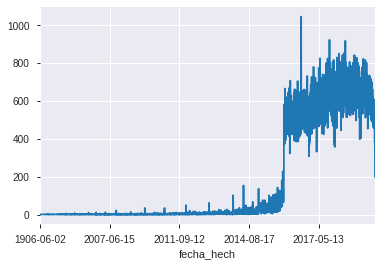

In [7]:
pivot_datetime(df, 'categoria_', 'fecha_hech', 'alcaldia_h', 
               formato='dia', aggfunc='count').sum(axis=0).plot()
plt.show()
df = df[df['fecha_hech'].dt.year>=2016]

Ahora nuestra tabla es ligeramente mas pequeña, pero podemos trabajar mejor con ella

Además, gráficaremos las coordenadas con geopandas para darnos una idea inicial de nuestros datos.

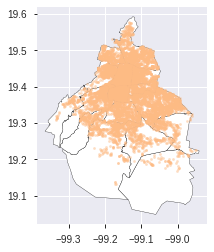

In [8]:
df.tail(10000).plot(ax = base.plot(color='white', edgecolor='black'), 
                    marker='o', color='#fdbb84', markersize=5, alpha=0.5)
plt.show()

In [9]:
profile = ProfileReport(df.tail(1000).drop('geometry', axis=1), title='Carpetas Investigación PGJ\nCiudad de México')
profile.to_file(output_file="'Carpetas_PGJ_CDMX'.html")

## 3. Análisis temporales

### 3.1 Series de tiempo
En primer lugar gráficaremos cuantos delitos hay por tipo de delito y alcaldía. 
Este análisis se puede agrupar por día, semana, mes o año. Cada escala temporal nos da datos distintos. Escoger la escala temporal adecuada es muy importante.

In [10]:
@interact

def serie_de_tiempo(delito = ['Todos'] + df['categoria_'].unique().tolist(), 
                    alcaldia = ['Ciudad de Mexico'] + alcaldias + ['Otro'], 
                    periodo = ['año','mes','semana','dia']):
    # selecionar por delito y alcaldía
    if delito=='Todos': df_=df
    else: df_ = df[df['categoria_']==delito]
    if alcaldia=='Ciudad de Mexico': df_=df_
    else: df_ = df_[df_['alcaldia_h']==alcaldia]
    
    print("Delito: {}\nLugar: {}\nTotal: {}".format(delito, alcaldia, df_.shape[0]))
    df_ = pivot_datetime(df_, 'categoria_', 'fecha_hech', 'alcaldia_h', 
                         formato=periodo, aggfunc='count')
    df_ = df_.sum(axis=0)
    df_.plot(title='{} en {} por {}'.format(delito, alcaldia, periodo))
    plt.show()

interactive(children=(Dropdown(description='delito', options=('Todos', 'Delito De Bajo Impacto', 'Hecho No Del…

### 3.2 Eventos cíclicos

Algunos eventos pueden ser afectados por el día del mes, de la semana o la hora

In [11]:
@interact

def serie_de_tiempo(delito = ['Todos'] + df['categoria_'].unique().tolist(), 
                    alcaldia = ['Ciudad de Mexico'] + alcaldias + ['Otro'], 
                    ciclo = ['dia_del_mes', 'dia_semana', 'hora']):
    # selecionar por delito y alcaldía
    if delito=='Todos': df_=df
    else: df_ = df[df['categoria_']==delito]
    if alcaldia=='Ciudad de Mexico': df_=df_
    else: df_ = df_[df_['alcaldia_h']==alcaldia]
    
    print("Delito: {}\nLugar: {}\nTotal: {}".format(delito, alcaldia, df_.shape[0]))
    df_ = pivot_datetime(df_, 'categoria_', 'fecha_hech', 'alcaldia_h', 
                         formato=ciclo, aggfunc='count')
    df_ = df_.sum(axis=0)
    df_.plot(title='{} en {} por {}'.format(delito, alcaldia, ciclo))
    plt.show()

interactive(children=(Dropdown(description='delito', options=('Todos', 'Delito De Bajo Impacto', 'Hecho No Del…

### 3.3 Frecuencia

Una pregunta importante es que tan frecuente es un evento, es decir, cada cuanto tiempo se comete un delito.

In [12]:
@interact

def frecuencia(delito = ['Todos'] + df['categoria_'].unique().tolist(), 
                    alcaldia = ['Ciudad de Mexico'] + alcaldias + ['Otro'], 
                    periodo = ['minuto', 'hora', 'día', 'semana', 'mes']):
    # selecionar por delito y alcaldía
    if delito=='Todos': df_=df
    else: df_ = df[df['categoria_']==delito]
    if alcaldia=='Ciudad de Mexico': df_=df_
    else: df_ = df_[df_['alcaldia_h']==alcaldia]
    if periodo=='minuto': dt=60
    if periodo=='hora':   dt=360
    if periodo=='día':    dt=360*24
    if periodo=='semana': dt=360*24*7
    if periodo=='mes':    dt=360*24*30
        
    df_ = df_['fecha_hech'].diff().dt.total_seconds().dropna().div(dt)
    
    print("Delito: {}\nLugar: {}\nTotal: {}\tPromedio: {}".format(delito, alcaldia, df_.shape[0], round(df_.mean(),3)))
    sns.distplot( df_, kde=False, bins = ceil(df_.max()) )
    plt.title('Frecuencia {} en {} por {}'.format(delito, alcaldia, periodo))
    plt.show()



interactive(children=(Dropdown(description='delito', options=('Todos', 'Delito De Bajo Impacto', 'Hecho No Del…

### 3.4 Comparaciones

Para entender un fenómeno muchas veces hay que entender la relación entre variables. Por ejemplo, podemos preguntarnos si la incidencia de un delito correlaciona con algún otro delito.

La correlación es la relación estadística entre dos variables. La formula de la correlación lineal es:
$$ \rho _{X,Y}
=\operatorname {corr} (X,Y)
={\operatorname {cov} (X,Y) \over \sigma _{X}\sigma _{Y}}
={\operatorname {E} [(X-\mu _{X})(Y-\mu _{Y})] \over \sigma _{X}\sigma _{Y}}
$$


In [13]:
@interact

def correlacion(alcaldia = ['Ciudad de Mexico'] + alcaldias + ['Otro']):
    if alcaldia=='Ciudad de Mexico': df_=df
    else: df_ = df[df['alcaldia_h']==alcaldia]
    
    df_ = pd.pivot_table(df_, aggfunc='count', index=df_['fecha_hech'].dt.strftime('%Y-%m-%d'), 
                          columns='categoria_', values='geometry', fill_value=0)
    df_ = df_.corr().dropna(how="all").dropna(axis=1,how="all")
    sns.set(font_scale = 0.7)
    fig = sns.clustermap(data=df_, 
                         cmap=sns.color_palette("BrBG", 15), 
                         vmin=-1, vmax=1     )
    fig.fig.suptitle("Correlación en la incidencia delictiva en {}".format(alcaldia)) 
    #fig.ax_heatmap.set_xticks([])
    #fig.ax_col_dendrogram.set_visible(False)
    fig.ax_row_dendrogram.set_visible(False)
    plt.show()

interactive(children=(Dropdown(description='alcaldia', options=('Ciudad de Mexico', 'Alvaro Obregon', 'Azcapot…